
# Hands-On Machine Learning: Core Topics

This notebook mirrors the style of the attached hands-on template and walks you through **six core topics** in Machine Learning:

1. Supervised Learning – Regression  
2. Supervised Learning – Classification  
3. Unsupervised Learning – Clustering  
4. Dimensionality Reduction  
5. Cross-Validation  
6. Bias–Variance and Overfitting

> **How to use this notebook**
> - Run each cell in order (Shift+Enter).
> - Read the short theory blocks, then experiment by changing parameters.
> - Complete the **Try it / Exercises** prompts sprinkled throughout.



## Learning Objectives

By the end of this notebook, you will be able to:

- Train and evaluate simple **regression** and **classification** models.
- Apply **K-Means** and **DBSCAN** for clustering and reason about their differences.
- Use **PCA** to reduce dimensionality and visualize high-dimensional datasets.
- Perform **K-fold cross-validation** and **grid search** for model selection.
- Interpret **learning curves** and **validation curves** to diagnose **under/overfitting**.



## Setup

We use common scientific Python libraries. If something is missing in your environment, install it via pip (uncomment the line below).


In [1]:

# If needed:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_regression, make_classification, make_blobs, load_iris

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print('Libraries imported.')


Libraries imported.



## 1. Supervised Learning – Regression


### Goal:
Predict a continuous target (e.g., house price).  
We start with a synthetic dataset and compare **Linear Regression** and **Ridge Regression**.

**Why Ridge?** Adds L2 penalty to shrink coefficients → often better test performance with noisy/correlated features.

**Metrics:** **MSE** (↓ better), **R²** (↑ better; can be < 0 on test).

### Steps
- Generate data with `make_regression`.
- Split with `train_test_split`.
- Fit `LinearRegression()` and `Ridge(alpha=1.0)`.
- Compute test **MSE** and **R²**.
- Plot test scatter + both prediction lines.

### Interpret
- Ridge better test MSE/R² ⇒ less overfitting.
- If Ridge underperforms, reduce `alpha`; too large `alpha` ⇒ underfit.

### Try
- Change `noise` in `make_regression`. How do MSE and R² respond?
- Vary `alpha` in `Ridge(alpha=...)`. When does Ridge help vs hurt?



Linear Regression:    MSE=166.59, R^2=0.841
Ridge Regression(α=1): MSE=167.11, R^2=0.840


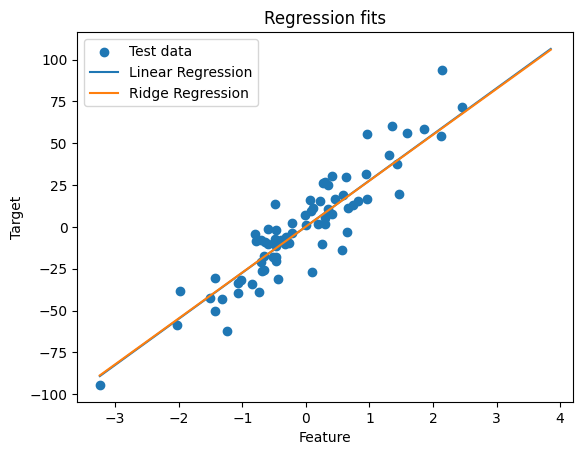

In [2]:

# Create a synthetic regression dataset
X, y = make_regression(n_samples=300, n_features=1, noise=12.0, random_state=RANDOM_STATE)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Models
linreg = LinearRegression().fit(X_train, y_train)
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE).fit(X_train, y_train)

# Predictions
y_pred_lin = linreg.predict(X_test)
y_pred_ridge = ridge.predict(X_test)

# Metrics
mse_lin = mean_squared_error(y_test, y_pred_lin)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_lin = r2_score(y_test, y_pred_lin)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Linear Regression:    MSE={mse_lin:.2f}, R^2={r2_lin:.3f}')
print(f'Ridge Regression(α=1): MSE={mse_ridge:.2f}, R^2={r2_ridge:.3f}')

# Visualization
plt.figure()
plt.scatter(X_test, y_test, label='Test data')
xs = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
plt.plot(xs, linreg.predict(xs), label='Linear Regression')
plt.plot(xs, ridge.predict(xs), label='Ridge Regression')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Regression fits')
plt.legend()
plt.show()



## 2. Supervised Learning – Classification

### Goal:
Predict a discrete class (e.g., species).  
We use a 2-class synthetic dataset to compare **Logistic Regression** and **SVM**.

### Steps
1. Generate a binary dataset with `make_classification` (tune `class_sep`).
2. Do a `train_test_split`.
3. Build two pipelines: `StandardScaler()` → `LogisticRegression()` and `SVC(kernel='rbf')`.
4. Evaluate **accuracy**; plot **confusion matrices**; print `classification_report`.

### Interpretation
- **SVM (RBF)** often wins when the decision boundary is non-linear.  
- **LogReg** is fast and interpretable for near-linear problems.  
- Use confusion matrices to see **which** classes are confused.

### Try / Experiments
- Vary `class_sep` and `n_informative`.  
- Change SVM kernel (`'linear'`, `'poly'`) and tune `C`, `gamma`.  
- Use `load_iris()` (3 classes) nd adapt the code to multiclass classification.


Logistic Regression accuracy: 0.976
SVM accuracy: 0.968


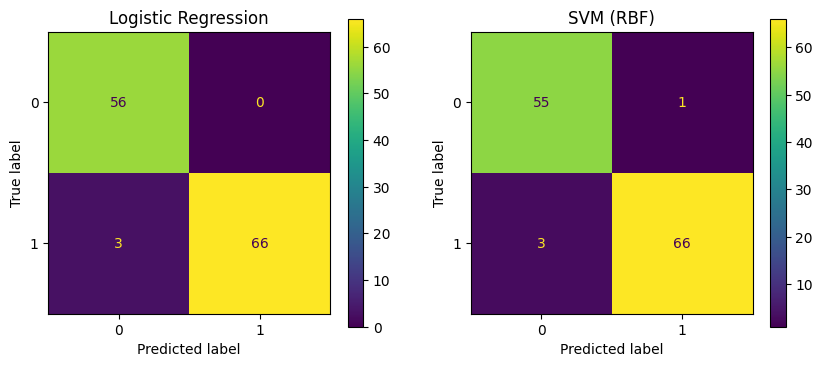


Classification report (SVM):

              precision    recall  f1-score   support

           0       0.95      0.98      0.96        56
           1       0.99      0.96      0.97        69

    accuracy                           0.97       125
   macro avg       0.97      0.97      0.97       125
weighted avg       0.97      0.97      0.97       125



In [3]:

# Synthetic 2-class dataset
X, y = make_classification(n_samples=500, n_features=4, n_informative=3, n_redundant=0,
                           n_clusters_per_class=1, class_sep=1.2, random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

# Pipelines with scaling
logreg_clf = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=200))])
svm_clf    = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', random_state=RANDOM_STATE))])

logreg_clf.fit(X_train, y_train)
svm_clf.fit(X_train, y_train)

pred_lr = logreg_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)

print('Logistic Regression accuracy:', accuracy_score(y_test, pred_lr))
print('SVM accuracy:', accuracy_score(y_test, pred_svm))

# Confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(10,4))
ConfusionMatrixDisplay.from_predictions(y_test, pred_lr, ax=axes[0])
axes[0].set_title('Logistic Regression')
ConfusionMatrixDisplay.from_predictions(y_test, pred_svm, ax=axes[1])
axes[1].set_title('SVM (RBF)')
plt.show()

print('\nClassification report (SVM):\n')
print(classification_report(y_test, pred_svm))



## 3. Unsupervised Learning – Clustering

### Goal:
Group similar points without labels.  


###  Algorithms

- K-Means: centroid-based, needs k, struggles with non-spherical shapes/outliers.
- DBSCAN: density-based, finds arbitrary shapes, flags noise (label = −1), no k.

### Steps

1. Generate blobs + add uniform noise.
2. Fit KMeans(n_clusters=4) → labels_km.
3. Fit DBSCAN(eps=0.9, min_samples=10) → labels_db.
4. Scatter-plot points colored by labels for both methods.

### Interpret

- K-Means: clean spherical clusters; noisy points get forced into nearest cluster.
- DBSCAN: can separate irregular clusters; noisy points → −1. Too small eps → over-fragmentation; too large → merges clusters.

### Try

- Vary cluster_std (data overlap).
- Sweep n_clusters for K-Means; plot inertia (elbow).
- Grid eps × min_samples for DBSCAN; count noise and clusters.
- Standardize features if scales differ.



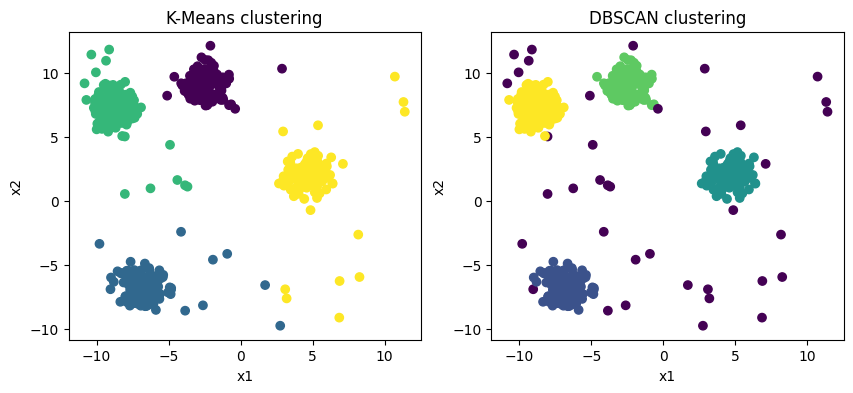

In [4]:

# 2D blobs with noise
X_blobs, _ = make_blobs(n_samples=600, centers=4, cluster_std=0.80, random_state=RANDOM_STATE)
# Add some random noise points
noise = np.random.uniform(low=X_blobs.min(), high=X_blobs.max(), size=(40, 2))
X_clust = np.vstack([X_blobs, noise])

# KMeans
kmeans = KMeans(n_clusters=4, n_init='auto', random_state=RANDOM_STATE).fit(X_clust)
labels_km = kmeans.labels_

# DBSCAN
db = DBSCAN(eps=0.9, min_samples=10).fit(X_clust)
labels_db = db.labels_  # -1 denotes noise

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].scatter(X_clust[:,0], X_clust[:,1], c=labels_km)
axes[0].set_title('K-Means clustering')
axes[1].scatter(X_clust[:,0], X_clust[:,1], c=labels_db)
axes[1].set_title('DBSCAN clustering')
for ax in axes:
    ax.set_xlabel('x1'); ax.set_ylabel('x2')
plt.show()



## 4. Dimensionality Reduction

### Goal:
Compress features while preserving structure.  
We use **PCA** to project to 2D for visualization.


### Steps

1. Load data (iris), set X, y.
2. Build Pipeline(StandardScaler() → PCA(n_components=2)).
3. fit_transform(X) → X_pca.
4. Scatter plot by class (PC1 vs PC2).
5. Print explained_variance_ratio_ and its sum.

### Interpret

- Classes separating in PC space ⇒ PCA captures meaningful variance.
- Explained variance (EVR): higher cumulative EVR ⇒ better 2D summary.
- If clusters overlap, 2 PCs may be insufficient or classes aren’t linearly separable.

### Try

- Change n_components (e.g., 3) and compare cumulative EVR.
- Remove scaling and observe impact.
- Use whiten=True and compare plots.


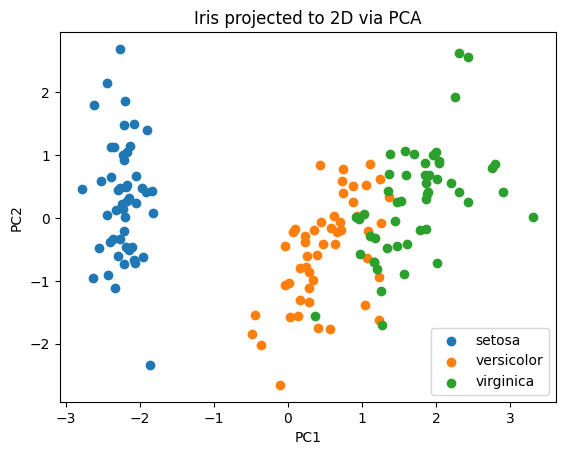

Explained variance ratio: [0.72962445 0.22850762]
Cumulative: 0.9581320720000166


In [5]:

iris = load_iris()
X = iris.data
y = iris.target
names = iris.target_names

# Standardize -> PCA -> 2D
pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2, random_state=RANDOM_STATE))])
X_pca = pca_pipe.fit_transform(X)

# Plot
plt.figure()
for cls in np.unique(y):
    idx = (y == cls)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], label=names[cls])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Iris projected to 2D via PCA')
plt.legend()
plt.show()

# Explained variance
pca = pca_pipe.named_steps['pca']
print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative:', pca.explained_variance_ratio_.sum())



## 5. Cross-Validation

We estimate generalization performance by splitting the data into multiple folds.

### Goal:
Use **K-Fold** and **`cross_val_score`** on classification with Logistic Regression.


### Method:
 Use K-Fold CV with a scaled Logistic Regression pipeline. Report fold scores and the mean. Then run GridSearchCV to pick the best C.

### Steps

1. Create data with make_classification.
2. Build Pipeline(StandardScaler(), LogisticRegression(...)).
3. Define KFold(n_splits=5, shuffle=True, random_state=...).
4. cross_val_score(..., scoring="accuracy") → fold scores + mean.
5. GridSearchCV over clf__C (and solver/penalty), fit, read best_params_, best_score_.

### Interpret

- Stable, high mean + low std ⇒ robust model.
- GridSearchCV selects C balancing bias/variance.

### Try

- Try `SVC` instead of `LogisticRegression` and grid-search `C` and `gamma`.
- Change `n_splits` to 3 or 10. How does variance of scores change?
- Use `scoring='roc_auc'` on a binary dataset and compare with accuracy.

In [6]:

X, y = make_classification(n_samples=600, n_features=6, n_informative=4, random_state=RANDOM_STATE)
pipe = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=300, random_state=RANDOM_STATE))])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scores = cross_val_score(pipe, X, y, cv=kf, scoring='accuracy')
print('Fold accuracies:', scores)
print('Mean accuracy:', scores.mean())

# Grid search example
param_grid = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs']
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=None)
grid.fit(X, y)
print('Best params:', grid.best_params_)
print('Best CV score:', grid.best_score_)


Fold accuracies: [0.65       0.74166667 0.725      0.7        0.675     ]
Mean accuracy: 0.6983333333333333
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best CV score: 0.6983333333333333



## 6. Bias–Variance and Overfitting

### Goal:
Understand model capacity vs data size/complexity.

We will:
- Plot a **learning curve** (train size vs. score) to see if more data would help.
- Plot a **validation curve** (hyperparameter vs. score) to see under/overfitting.



### Steps

1. Build a DecisionTreeClassifier pipeline.
2. Use learning_curve with train_sizes=np.linspace(0.1,1.0,6).
3. Plot training vs CV accuracy.
4. Use validation_curve over max_depth=1..20.
5. Plot train vs CV accuracy vs max_depth.

### Interpret

- High train, low CV ⇒ overfitting (reduce complexity / more data).
- Low train and CV ⇒ underfitting (increase complexity / features).
- Learning curve flat & gap large ⇒ more data may help; if both low, increase model capacity.

### Try

- Repeat with `DecisionTreeClassifier(min_samples_leaf=...)`. How does it affect overfitting?
- Swap in `Ridge` (regression) and use `validation_curve` over `alpha`.
- Change dataset size and noise; re-plot learning curves to see effects.

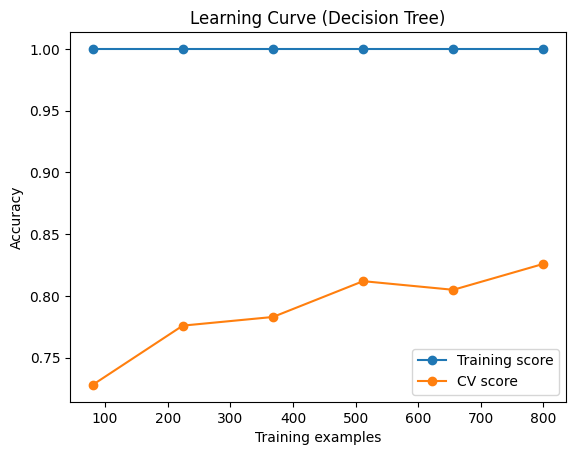

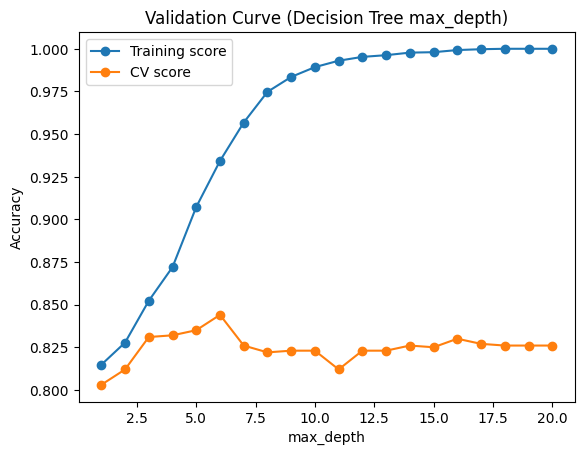

In [7]:

from sklearn.tree import DecisionTreeClassifier

X, y = make_classification(n_samples=1000, n_features=20, n_informative=6, class_sep=1.0, random_state=RANDOM_STATE)
pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    pipe, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 6), scoring='accuracy', random_state=RANDOM_STATE
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker='o', label='Training score')
plt.plot(train_sizes, test_mean, marker='o', label='CV score')
plt.xlabel('Training examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Decision Tree)')
plt.legend()
plt.show()

# Validation curve over max_depth
param_range = np.arange(1, 21)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(random_state=RANDOM_STATE), X, y,
    param_name='max_depth', param_range=param_range, cv=5, scoring='accuracy'
)

plt.figure()
plt.plot(param_range, train_scores.mean(axis=1), marker='o', label='Training score')
plt.plot(param_range, test_scores.mean(axis=1), marker='o', label='CV score')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve (Decision Tree max_depth)')
plt.legend()
plt.show()



## Wrap-up

In this hands-on you practiced:
- Building and evaluating **regression** and **classification** models
- Applying **K-Means** and **DBSCAN** for clustering
- Using **PCA** to reduce dimensions and visualize data
- Doing **K-fold cross-validation** and **grid search**
- Reading **learning** and **validation curves** to reason about **bias–variance**

